## Expanded URLs
**Purpose**: 
- Process the expanded/resolved version of the URLs which were (re-)tweeted by congressional Republicans during 2016-2020.
- Note: this project uses a [forked version of urlExpander](https://github.com/wlmwng/urlExpander).

In [1]:
import os
import json
import pandas as pd
import plotnine as p9
import urlexpander
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
dir_fig = os.path.join("..", "..", "figures")
dir_url = os.path.join('..', '..', 'data', '02-intermediate', '02-twitter')

### Load expanded URLs

In [3]:
urls = pd.read_pickle(os.path.join(dir_url, f"politicians_tweeted_urls_resolved.pkl"))

In [4]:
urls.columns

Index(['tweet_id', 'created_at', 'created_week', 'created_month',
       'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
       'url', 'expanded_url', 'display_url', 'unwound_url',
       'most_unrolled_url', 'most_unrolled_field', 'is_dupe', 'is_from_tw',
       'resolved_url'],
      dtype='object')

### Process the Twitter URL options. The `standardized_url` which will be used to match into the outlet URLs from Media Cloud.
- `most_unrolled_url`: the original URL given to urlExpander
- `resolved_url`: the URL returned from the expansion attempt
- `selected_url`: the URL selected for standardization
- `standardized_url`: the URL used for matching

In [5]:
urls["resolved_url_is_generic"] = urls["resolved_url"].map(lambda x: urlexpander.url_utils.is_generic_url(x))

In [6]:
def select_url(row):
    """Select the URL which will be processed for URL matching.
    - if the attempt returned an error or a generic URL -> use the original URL from Twitter,
    - if the attempt returned a generic URL -> use the original URL from Twitter,
    - otherwise, consider the attempt successful and use "resolved_url".
    """
    if "ERROR" in row["resolved_url"] or row["resolved_url_is_generic"]:
        selected_url = row["most_unrolled_url"]
    else:
        selected_url = row["resolved_url"]
    return selected_url

In [7]:
urls["selected_url"] = urls.apply(lambda r: select_url(r), axis=1)

### Process selected URL

In [8]:
urls.columns

Index(['tweet_id', 'created_at', 'created_week', 'created_month',
       'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
       'url', 'expanded_url', 'display_url', 'unwound_url',
       'most_unrolled_url', 'most_unrolled_field', 'is_dupe', 'is_from_tw',
       'resolved_url', 'resolved_url_is_generic', 'selected_url'],
      dtype='object')

In [9]:
%%time
urls['standardized_netloc'] = urls['selected_url'].map(lambda x: urlexpander.url_utils.standardize_url(url=x,
                                                                                                   remove_scheme=True,
                                                                                                   replace_netloc_with_domain=False,
                                                                                                   remove_path=True,
                                                                                                   remove_query=True,
                                                                                                   remove_fragment=True,
                                                                                                   to_lowercase=True,))
urls['standardized_domain'] = urls['selected_url'].map(lambda x: urlexpander.url_utils.get_domain(url=x))
urls['standardized_url'] = urls['selected_url'].map(lambda x: urlexpander.url_utils.standardize_url(url=x,
                                                                                                    remove_scheme=True,
                                                                                                    replace_netloc_with_domain=False,
                                                                                                    remove_path=False,
                                                                                                    remove_query=False,
                                                                                                    remove_fragment=True,
                                                                                                    to_lowercase=True,))
urls['standardized_url_is_generic'] = urls['selected_url'].map(lambda x: urlexpander.url_utils.is_generic_url(x))

CPU times: user 1min 18s, sys: 58.2 ms, total: 1min 18s
Wall time: 1min 18s


In [10]:
def extract_error(resolved_url):
    if 'CLIENT_ERROR' in resolved_url:
        res = 'CLIENT_ERROR'
    elif 'CONNECTIONPOOL_ERROR' in resolved_url:
        res = 'CONNECTIONPOOL_ERROR'
    else:
        res = 'no error'
    return res

In [11]:
urls['urlexpander_error'] = urls['resolved_url'].map(lambda x: extract_error(x))

- export the URLs

In [12]:
urls.columns

Index(['tweet_id', 'created_at', 'created_week', 'created_month',
       'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
       'url', 'expanded_url', 'display_url', 'unwound_url',
       'most_unrolled_url', 'most_unrolled_field', 'is_dupe', 'is_from_tw',
       'resolved_url', 'resolved_url_is_generic', 'selected_url',
       'standardized_netloc', 'standardized_domain', 'standardized_url',
       'standardized_url_is_generic', 'urlexpander_error'],
      dtype='object')

In [13]:
urls = urls[['tweet_id', 'created_at', 'created_week', 'created_month',
             'created_year', 'text', 'author_id', 'username', 'tweet_url', 'url_id',
             'url', 'expanded_url', 'display_url', 'unwound_url',
             'most_unrolled_url', 'most_unrolled_field', 'is_dupe',
             'is_from_tw', 'resolved_url', 'selected_url', 'standardized_url', 'standardized_netloc', 'standardized_domain',
             'standardized_url_is_generic', 'urlexpander_error']]

urls.to_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_urlexpander.pkl'))

- spot-check the URLs

In [14]:
urls = pd.read_pickle(os.path.join(dir_url, f'politicians_tweeted_urls_urlexpander.pkl'))

In [15]:
# examples of generic URLs
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    display(
        urls.loc[urls["standardized_url_is_generic"]][
            [
                "most_unrolled_url",
                "resolved_url",
                "selected_url",
                "standardized_url",
                "standardized_url_is_generic",
            ]
        ].sample(n=30, random_state=42)
    )


,most_unrolled_url,resolved_url,selected_url,standardized_url,standardized_url_is_generic
129334,https://fdrlibrary.org/,https://www.fdrlibrary.org/,https://fdrlibrary.org/,fdrlibrary.org,True
74411,https://www.azfsn.org/,https://www.azfsn.org/,https://www.azfsn.org/,www.azfsn.org,True
46934,https://my2020census.gov/,http://2020census.gov/__CLIENT_ERROR__,https://my2020census.gov/,my2020census.gov,True
281753,http://TestNebraska.com,https://www.testnebraska.com/,http://TestNebraska.com,testnebraska.com,True
264289,http://redcross.org,https://www.redcross.org/,http://redcross.org,redcross.org,True
78259,http://readthebill.gop,http://readthebill.gop/__CONNECTIONPOOL_ERROR__,http://readthebill.gop,readthebill.gop,True
116501,https://financialservices.house.gov/,https://financialservices.house.gov/,https://financialservices.house.gov/,financialservices.house.gov,True
46642,http://www.opensecrets.org,http://www.opensecrets.org/,http://www.opensecrets.org,www.opensecrets.org,True
246857,https://www.disasterassistance.gov/,https://www.disasterassistance.gov/,https://www.disasterassistance.gov/,www.disasterassistance.gov,True
16170,http://HealthCare.gov,https://www.healthcare.gov/,http://HealthCare.gov,healthcare.gov,True


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(urls[['resolved_url', 'standardized_url', 'standardized_url_is_generic']].sample(n=30, random_state=42))

,resolved_url,standardized_url,standardized_url_is_generic
179007,https://www.politico.com/news/2020/06/21/john-hickenlooper-colorado-senate-stumble-330755,www.politico.com/news/2020/06/21/john-hickenlooper-colorado-senate-stumble-330755,False
225653,https://vekeo.com/event/aarpindiana-47407/,vekeo.com/event/aarpindiana-47407,False
146179,http://www.heraldonline.com/__CONNECTIONPOOL_ERROR__,www.heraldonline.com/news/local/article193891144.html,False
168114,https://www.youtube.com/watch?v=hsxaYAUMUZI&feature=youtu.be,www.youtube.com/watch?feature=youtu.be&v=hsxayaumuzi,False
186250,https://www.latimes.com/opinion/op-ed/la-oe-osborne-charter-schools-20190128-story.html,www.latimes.com/opinion/op-ed/la-oe-osborne-charter-schools-20190128-story.html,False
121543,https://kinzinger.house.gov/news/documentsingle.aspx?DocumentID=399457,kinzinger.house.gov/news/documentsingle.aspx?documentid=399457,False
25416,http://instagram.com/__CLIENT_ERROR__,www.instagram.com/accounts/login,False
229769,https://wnax.com/,wnax.com,True
217145,https://www.today.com/health/nurses-pray-over-patients-families-helipad-hospital-s-roof-t177344,www.today.com/health/nurses-pray-over-patients-families-helipad-hospital-s-roof-t177344,False
42396,https://www.wsj.com/articles/u-s-australia-bolster-health-security-cooperation-in-face-of-coronavirus-china-11595964310?mod=politics_lead_pos11&mod=djemCapitalJournalDaybreak,www.wsj.com/articles/u-s-australia-bolster-health-security-cooperation-in-face-of-coronavirus-china-11595964310?mod=djemcapitaljournaldaybreak,False


In [17]:
urls['urlexpander_error'].value_counts()

no error                197994
CLIENT_ERROR             56921
CONNECTIONPOOL_ERROR     30532
Name: urlexpander_error, dtype: int64

In [18]:
urls['urlexpander_error'].value_counts(normalize=True)

no error                0.693628
CLIENT_ERROR            0.199410
CONNECTIONPOOL_ERROR    0.106962
Name: urlexpander_error, dtype: float64

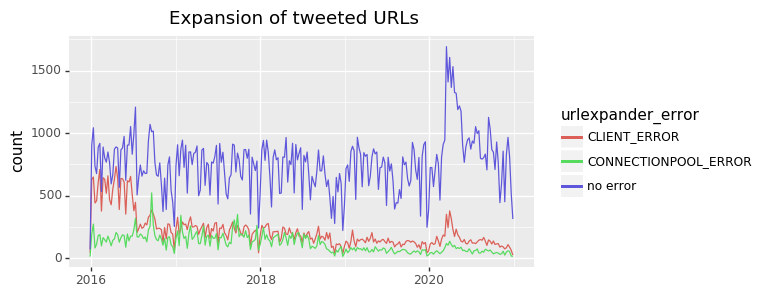

<ggplot: (8762083143671)>

In [19]:
plt = (p9.ggplot(urls, p9.aes(x='created_week'))
+ p9.geom_line(p9.aes(color='urlexpander_error'), stat='count')
+ p9.scale_x_datetime(name='',
                      breaks=date_breaks('2 years'),
                      labels=date_format('%Y'))
+ p9.theme(figure_size=(6,3),
           legend_position='right',
           subplots_adjust={'hspace':0.5})
+ p9.labs(title = f"Expansion of tweeted URLs"))

plt

In [20]:
# count of retrieved URLs per outlet by month from 2016 - 2020
# plt.save(os.path.join(dir_fig, 'c0204_urlExpander_timeline.svg'))